# Seq2seq (Encoder+Decoder) LSTM

In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
import tensorflow as tf
tf.random.set_seed(0)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
TRAIN_RANGE = (datetime(1949, 1, 1), datetime(1956, 12, 1))
VALID_RANGE = (datetime(1957, 1, 1), datetime(1958, 12, 1))
TEST_RANGE = (datetime(1959, 1, 1), datetime(1960, 12, 1))
ENCODER_TIMESTEPS = 12  # Input 12 months to predict next month
DECODER_TIMESTEPS = 6  # Slide 6 months when decoder predicts

## 1. Read in dataset

In [5]:
data = pd.read_csv('data/airline-passengers.csv')
data.index = pd.to_datetime(data.Month)  # Set datetime index
data.drop(['Month'], axis=1, inplace=True)

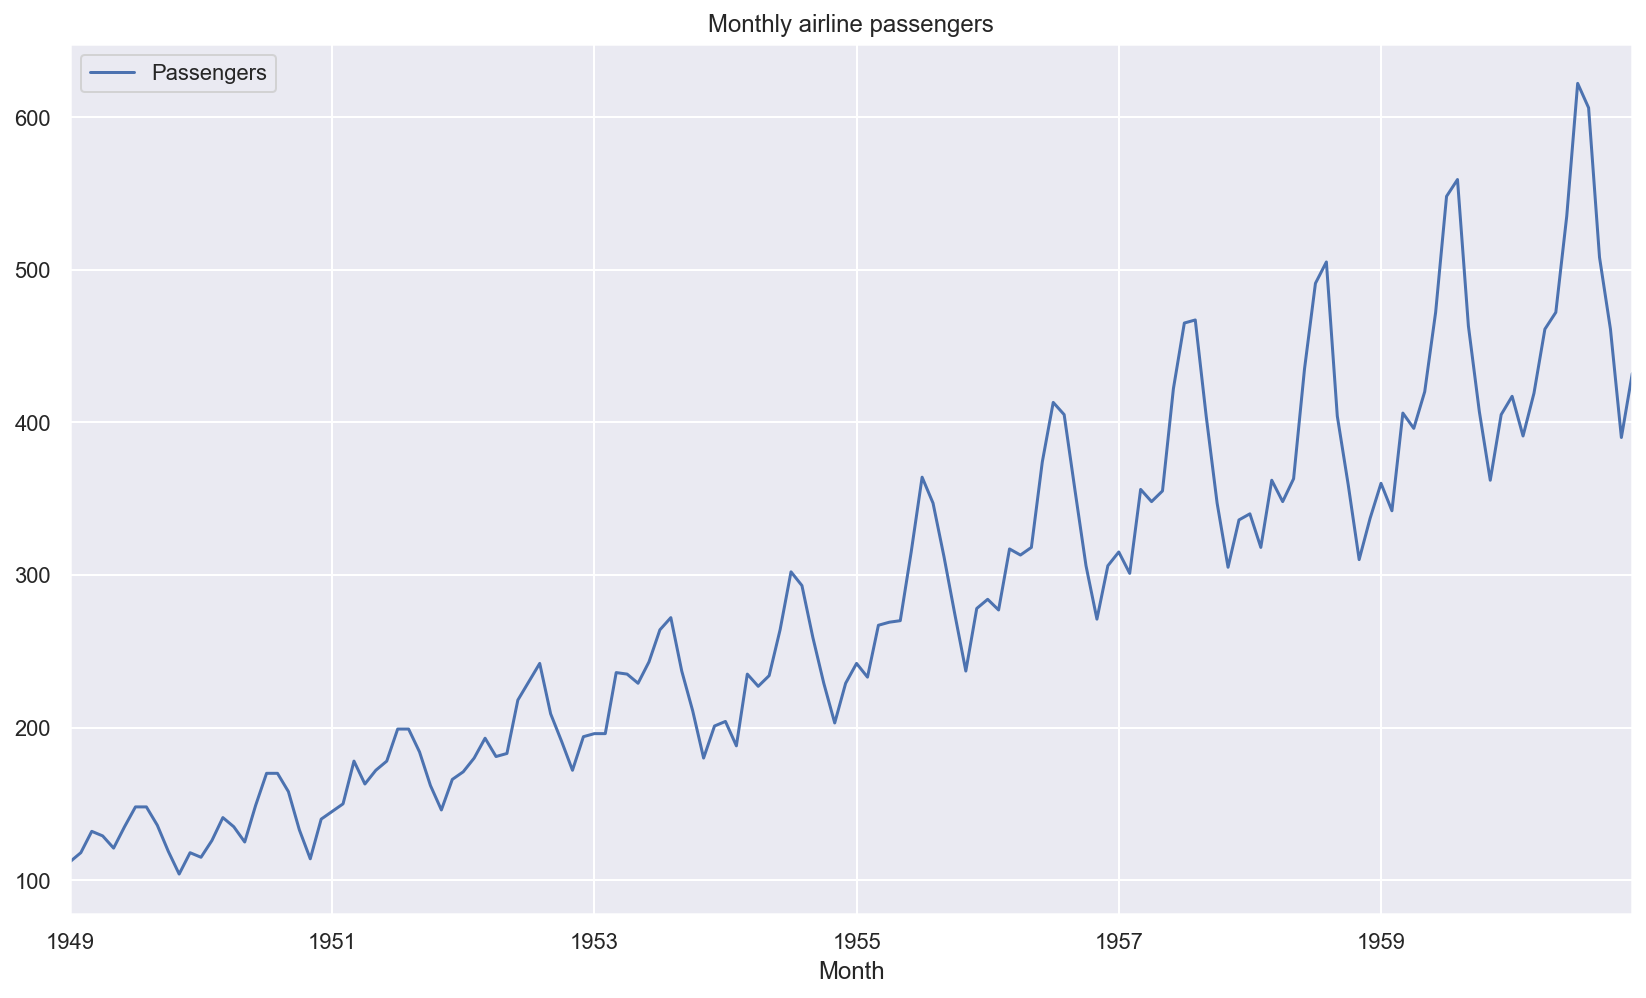

In [6]:
data.plot(figsize=(14, 8), title='Monthly airline passengers')

## 2.1 Normalize dataset

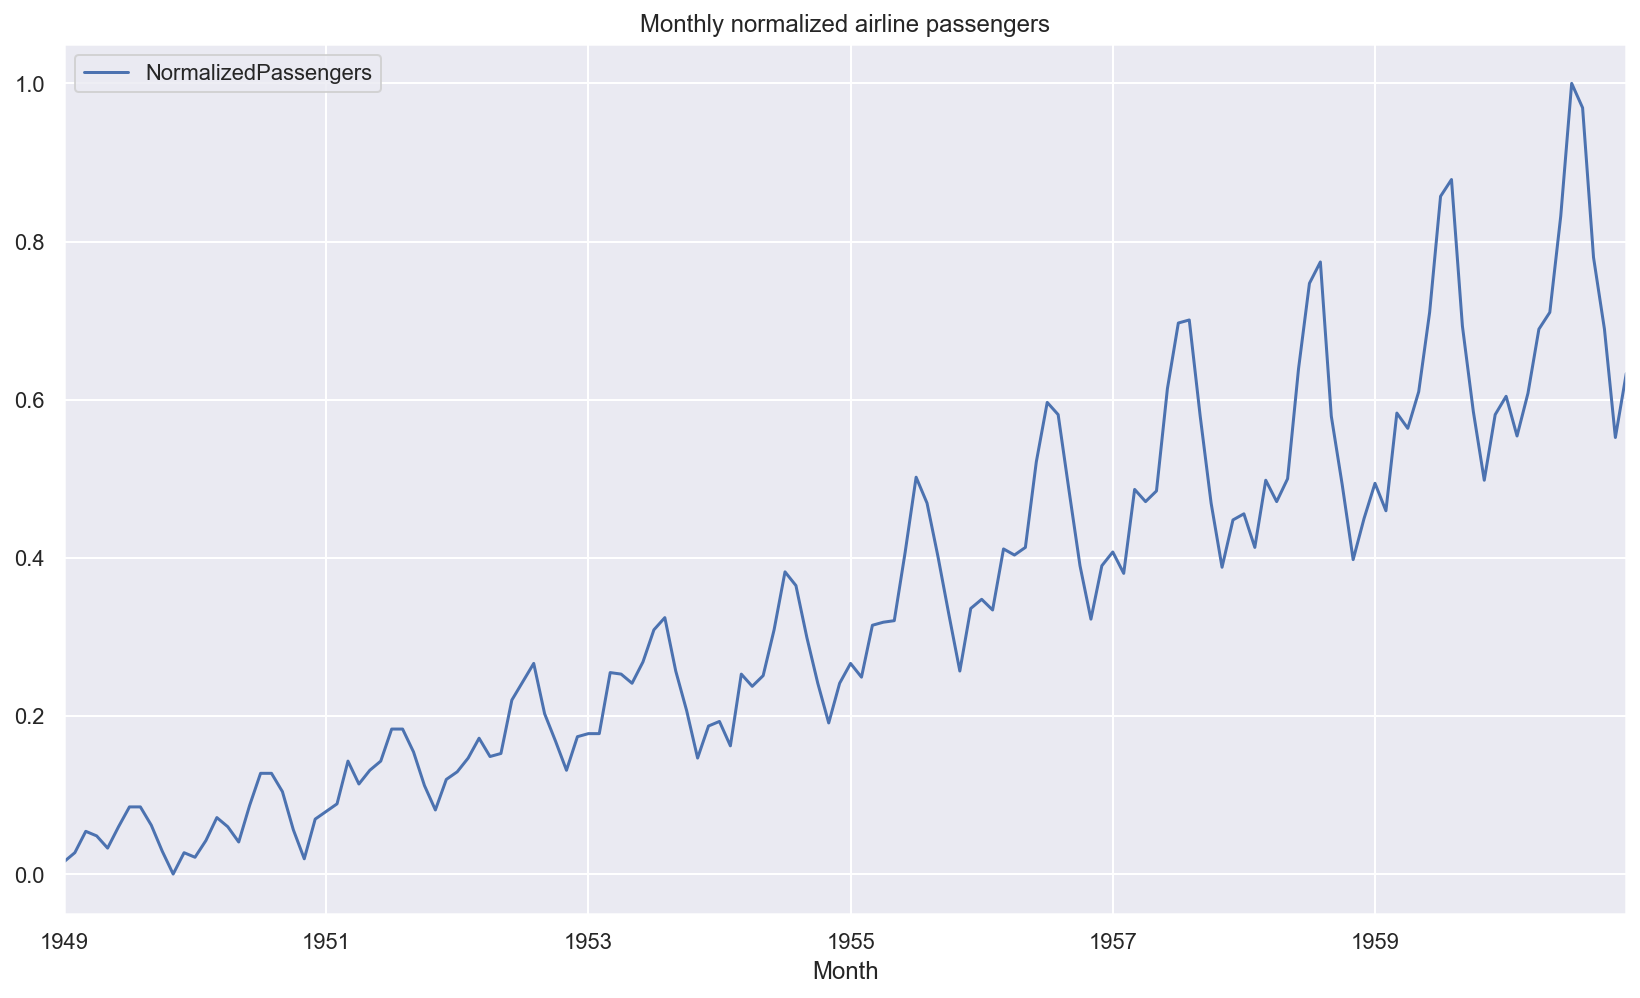

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['NormalizedPassengers'] = scaler.fit_transform(data['Passengers'].values.reshape(-1, 1)).flatten()
data[['NormalizedPassengers']].plot(figsize=(14, 8), title='Monthly normalized airline passengers')

## 2.2 Preprocess dataset

In [8]:
def create_dataset(data, enc_timesteps=ENCODER_TIMESTEPS, dec_timesteps=DECODER_TIMESTEPS):
    """Create input and output pairs for training lstm.
    Params:
        data (pandas.DataFrame): Normalized dataset
        enc_timesteps (int, default: ENCODER_TIMESTEPS): Input time length of encoder
        dec_timesteps (int, default: DECODER_TIMESTEPS): Input time length of decoder
    Returns:
        X_encoder (numpy.array): Input for encoder
        X_decoder (numpy.array): Input for decoder
        y (numpy.array): Output for decoder
        y_date (list): Datetime of output
        start_values (list): Start valeus of each input
    """
    X_encoder, X_decoder, y, y_date, start_values = [], [], [], [], []
    
    for i in range(len(data) - enc_timesteps - dec_timesteps):
        Xt_encoder = data.iloc[i:i+enc_timesteps].values
        Xt_decoder = data.iloc[i+enc_timesteps-dec_timesteps:i+enc_timesteps].values
        yt = data.iloc[i+enc_timesteps:i+enc_timesteps+dec_timesteps].values
        yt_date = data.index[i+enc_timesteps].to_pydatetime()  # Get start date of decoder output
        
        # Subtract a start value from each values in the timestep.
        start_value = Xt_encoder[0]
        Xt_encoder = Xt_encoder - start_value
        Xt_decoder = Xt_decoder - start_value
        yt = yt - start_value
        
        X_encoder.append(Xt_encoder)
        X_decoder.append(Xt_decoder)
        y.append(yt)
        y_date.append(yt_date)
        start_values.append(start_value)
        
    return np.array(X_encoder), np.array(X_decoder), np.array(y), y_date, start_values

In [9]:
def split_train_valid_test(X_encoder, X_decoder, y, y_date, train_range=TRAIN_RANGE, valid_range=VALID_RANGE, test_range=TEST_RANGE):
    """Split X and y into train, valid, and test periods.
    Params:
        X_encoder (numpy.array): Input for encoder
        X_decoder (numpy.array): Input for decoder
        y (numpy.array): Output for lstm
        y_date (list): Datetime of output
        train_range (tuple): Train period
        valid_range (tuple): Validation period
        test_range (tuple): Test period
    Returns:
        X_encoder_train (pandas.DataFrame), X_decoder_train (pandas.DataFrame)
        X_encoder_valid (pandas.DataFrame), X_decoder_valid (pandas.DataFrame)
        X_encoder_test (pandas.DataFrame), X_decoder_test (pandas.DataFrame)
        y_train (pandas.DataFrame)
        y_valid (pandas.DataFrame)
        y_test (pandas.DataFrame)
        y_date_train (list)
        y_date_valid (list)
        y_date_test (list)
    """
    train_end_idx = y_date.index(train_range[1])
    valid_end_idx = y_date.index(valid_range[1])
    
    X_encoder_train = X_encoder[:train_end_idx+1, :]
    X_encoder_valid = X_encoder[train_end_idx+1:valid_end_idx+1, :]
    X_encoder_test = X_encoder[valid_end_idx+1:, :]
    
    X_decoder_train = X_decoder[:train_end_idx+1, :]
    X_decoder_valid = X_decoder[train_end_idx+1:valid_end_idx+1, :]
    X_decoder_test = X_decoder[valid_end_idx+1:, :]
    
    y_train = y[:train_end_idx+1]
    y_valid = y[train_end_idx+1:valid_end_idx+1]
    y_test = y[valid_end_idx+1:]
    
    y_date_train = y_date[:train_end_idx+1]
    y_date_valid = y_date[train_end_idx+1:valid_end_idx+1]
    y_date_test = y_date[valid_end_idx+1:]
    
    return X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, X_encoder_test, X_decoder_test, \
                y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test

In [10]:
# Create input and output pairs for training lstm.
X_encoder, X_decoder, y, y_date, start_values = create_dataset(data[['NormalizedPassengers']])

# Split X and y into train, valid, and test periods.
X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, X_encoder_test, X_decoder_test, \
    y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test = split_train_valid_test(X_encoder, X_decoder, y, y_date)

In [11]:
print(X_encoder_train.shape, X_encoder_valid.shape, X_encoder_test.shape)
print(X_decoder_train.shape, X_decoder_valid.shape, X_decoder_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(84, 12, 1) (24, 12, 1) (18, 12, 1)
(84, 6, 1) (24, 6, 1) (18, 6, 1)
(84, 6, 1) (24, 6, 1) (18, 6, 1)


## 3. Create seq2seq (Encoder+Decoder) LSTM model

In [12]:
def create_model(enc_timesteps=ENCODER_TIMESTEPS, dec_timesteps=DECODER_TIMESTEPS):
    # Create encoder
    encoder_inputs = Input(shape=(enc_timesteps, 1), name='encoder_input')
    encoder, state_h1, state_c1 = LSTM(128, return_sequences=True, return_state=True, name='encoder_lstm_1')(encoder_inputs)
    encoder_states1 = [state_h1, state_c1]
    
    encoder_outputs, state_h2, state_c2 = LSTM(32, return_state=True, name='encoder_lstm_2')(encoder)
    encoder_states2 = [state_h2, state_c2]

    # Create decoder
    decoder_inputs = Input(shape=(dec_timesteps, 1), name='decoder_input')    
    decoder, _, _ = LSTM(128, return_sequences=True, return_state=True, name='decoder_lstm_1')(decoder_inputs, initial_state=encoder_states1)
    decoder, _, _ = LSTM(32, return_sequences=True, return_state=True, name='decoder_lstm_2')(decoder, initial_state=encoder_states2)

    
    # Create output layer
    decoder_outputs = Dense(1)(decoder)
    
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=0.01), metrics=['mean_absolute_error'])
    return model

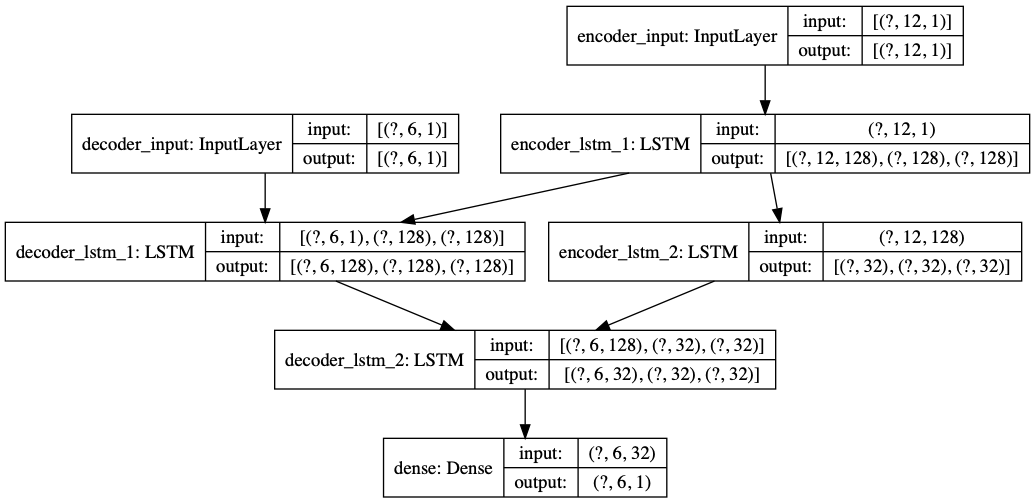

In [13]:
# Create model
model = create_model()
plot_model(model, show_shapes=True)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 12, 1)]      0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 6, 1)]       0                                            
__________________________________________________________________________________________________
encoder_lstm_1 (LSTM)           [(None, 12, 128), (N 66560       encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_lstm_1 (LSTM)           [(None, 6, 128), (No 66560       decoder_input[0][0]              
                                                                 encoder_lstm_1[0][1]         

In [15]:
# Callbacks of training.
es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=0, patience=15, verbose=1, mode='auto')
fn = 'trained_model.h5'
mc = ModelCheckpoint(filepath=fn, save_best_only=True)
callbacks = [es, mc]

In [16]:
# Start training model.
fit = model.fit(
    [X_encoder_train, X_decoder_train], y_train, 
    batch_size=32,
    epochs=1000, 
    verbose=2,
    validation_data=([X_encoder_valid, X_decoder_valid], y_valid), 
    callbacks=callbacks)

Train on 84 samples, validate on 24 samples
Epoch 1/1000
84/84 - 5s - loss: 0.0181 - mean_absolute_error: 0.1153 - val_loss: 0.0184 - val_mean_absolute_error: 0.1060
Epoch 2/1000
84/84 - 0s - loss: 0.0062 - mean_absolute_error: 0.0606 - val_loss: 0.0165 - val_mean_absolute_error: 0.1005
Epoch 3/1000
84/84 - 0s - loss: 0.0052 - mean_absolute_error: 0.0542 - val_loss: 0.0163 - val_mean_absolute_error: 0.0977
Epoch 4/1000
84/84 - 0s - loss: 0.0054 - mean_absolute_error: 0.0558 - val_loss: 0.0153 - val_mean_absolute_error: 0.1025
Epoch 5/1000
84/84 - 0s - loss: 0.0045 - mean_absolute_error: 0.0512 - val_loss: 0.0141 - val_mean_absolute_error: 0.0930
Epoch 6/1000
84/84 - 0s - loss: 0.0047 - mean_absolute_error: 0.0503 - val_loss: 0.0134 - val_mean_absolute_error: 0.0972
Epoch 7/1000
84/84 - 0s - loss: 0.0044 - mean_absolute_error: 0.0523 - val_loss: 0.0123 - val_mean_absolute_error: 0.0895
Epoch 8/1000
84/84 - 0s - loss: 0.0042 - mean_absolute_error: 0.0467 - val_loss: 0.0109 - val_mean_abs

Epoch 67/1000
84/84 - 0s - loss: 8.5413e-04 - mean_absolute_error: 0.0223 - val_loss: 0.0050 - val_mean_absolute_error: 0.0548
Epoch 68/1000
84/84 - 0s - loss: 8.0205e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0052 - val_mean_absolute_error: 0.0554
Epoch 69/1000
84/84 - 0s - loss: 7.7362e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0053 - val_mean_absolute_error: 0.0583
Epoch 70/1000
84/84 - 0s - loss: 7.8023e-04 - mean_absolute_error: 0.0212 - val_loss: 0.0048 - val_mean_absolute_error: 0.0518
Epoch 71/1000
84/84 - 0s - loss: 8.9537e-04 - mean_absolute_error: 0.0236 - val_loss: 0.0050 - val_mean_absolute_error: 0.0565
Epoch 72/1000
84/84 - 0s - loss: 8.2341e-04 - mean_absolute_error: 0.0216 - val_loss: 0.0048 - val_mean_absolute_error: 0.0537
Epoch 73/1000
84/84 - 0s - loss: 7.6891e-04 - mean_absolute_error: 0.0216 - val_loss: 0.0044 - val_mean_absolute_error: 0.0512
Epoch 74/1000
84/84 - 0s - loss: 8.0774e-04 - mean_absolute_error: 0.0216 - val_loss: 0.0043 - val_mean_absolut

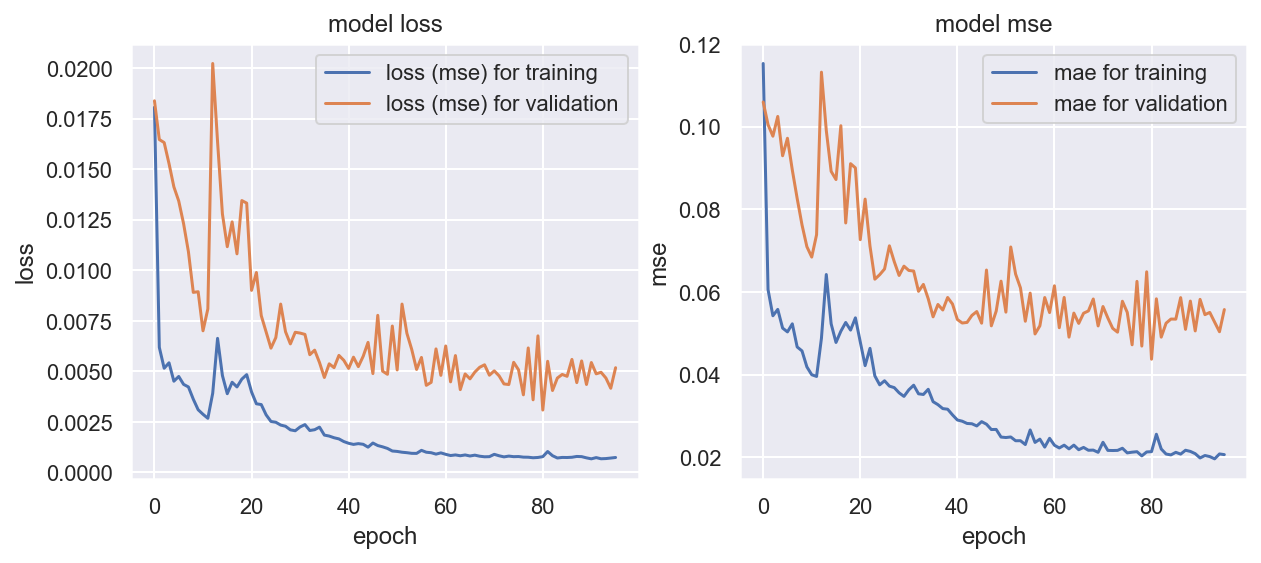

In [17]:
# Plot training history
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10, 4))
axL.plot(fit.history['loss'], label="loss (mse) for training")
axL.plot(fit.history['val_loss'], label="loss (mse) for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')

axR.plot(fit.history['mean_absolute_error'], label="mae for training")
axR.plot(fit.history['val_mean_absolute_error'], label="mae for validation")
axR.set_title('model mse')
axR.set_xlabel('epoch')
axR.set_ylabel('mse')
axR.legend(loc='upper right')

plt.show()

# Load best model
model = load_model(fn)

In [18]:
def evaluate_model(data, scaler, X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, \
                   X_encoder_test, X_decoder_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model, \
                  pred_timesteps=0):
    """Evaluate trained model by rmse (root mean squared error) and mae (mean absolute error)'
    Params:
        pred_timesteps (int): (t + T + pred_timesteps)th month if predicted from t ~ t + T months
    """
    
    # Predict next month passengers
    pred_train = model.predict([X_encoder_train, X_decoder_train])[:, pred_timesteps]
    pred_valid = model.predict([X_encoder_valid, X_decoder_valid])[:, pred_timesteps]
    pred_test = model.predict([X_encoder_test, X_decoder_test])[:, pred_timesteps]
    
    # Add start_values that were subtracted when preprocessing.
    pred_train  = pred_train + start_values[:len(X_encoder_train)]
    pred_valid  = pred_valid + start_values[len(X_encoder_train):len(X_encoder_train)+len(X_encoder_valid)]
    pred_test  = pred_test + start_values[len(X_encoder_train)+len(X_encoder_valid):]
    
    # Inverse transform normalization
    pred_train = scaler.inverse_transform(pred_train).flatten()
    pred_valid = scaler.inverse_transform(pred_valid).flatten()
    pred_test = scaler.inverse_transform(pred_test).flatten()
    
    # Plot prediction result
    pred_df = pd.DataFrame({
        'Passengers': data['Passengers'].values,
        'PredictionTrain': np.nan, 'PredictionValid': np.nan, 'PredictionTest': np.nan
    })
    
    train_start_idx = ENCODER_TIMESTEPS + pred_timesteps
    valid_start_idx = train_start_idx + len(pred_train)
    test_start_idx = valid_start_idx + len(pred_valid)
    
    pred_df.loc[train_start_idx:valid_start_idx - 1, 'PredictionTrain'] = pred_train
    pred_df.loc[valid_start_idx:test_start_idx-1, 'PredictionValid'] = pred_valid
    pred_df.loc[test_start_idx:test_start_idx+ len(pred_test)-1, 'PredictionTest'] = pred_test
    
    pred_df.idx =  data.index
    pred_df[['Passengers', 'PredictionTrain', 'PredictionValid', 'PredictionTest']].plot(figsize=(12, 6), title='Predicted monthly airline passengers')
    
    # Add start_values that were subtracted when preprocessing.
    y_train  = y_train[:, pred_timesteps] + start_values[:len(X_encoder_train)]
    y_valid  = y_valid[:, pred_timesteps] + start_values[len(X_encoder_train):len(X_encoder_train)+len(X_encoder_valid)]
    y_test  = y_test[:, pred_timesteps] + start_values[len(X_encoder_train)+len(X_encoder_valid):]
    
    # Inverse transform normalization
    y_train = scaler.inverse_transform(y_train).flatten()
    y_valid = scaler.inverse_transform(y_valid).flatten()
    y_test = scaler.inverse_transform(y_test).flatten()
    
    # Evaluate prediction scores of model.
    for y, pred, mode in zip([y_train, y_valid, y_test], [pred_train, pred_valid, pred_test], ['train', 'valid', 'test']):
        rmse = np.sqrt(mean_squared_error(y, pred))
        mae = mean_absolute_error(y, pred)
        print(f'{mode} rmse: {rmse:.06f}, mae: {mae:.06f}')

train rmse: 12.724724, mae: 9.969391
valid rmse: 24.477045, mae: 18.644954
test rmse: 19.383388, mae: 15.974626


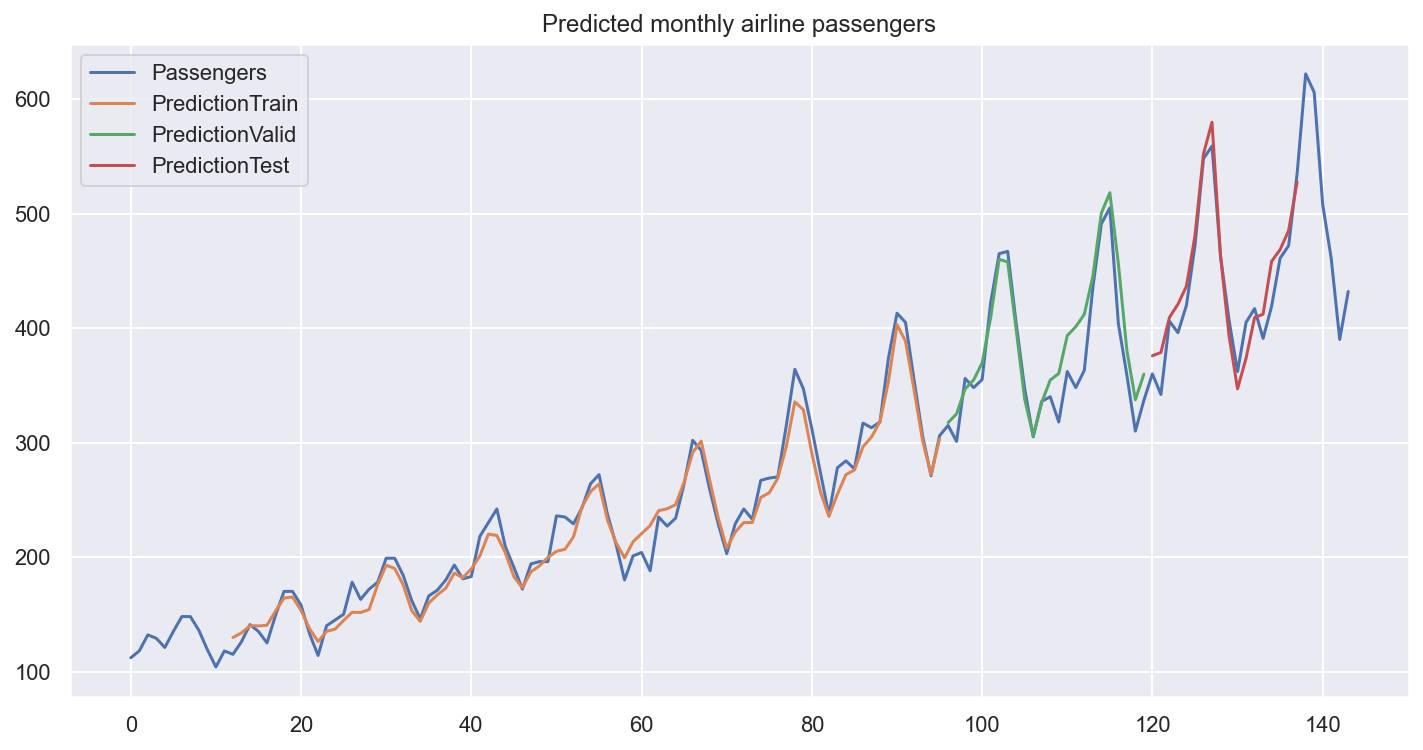

In [19]:
# Predict next month.
evaluate_model(data, scaler, X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, \
               X_encoder_test, X_decoder_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model, \
              pred_timesteps=0)

train rmse: 16.931535, mae: 13.272946
valid rmse: 28.843628, mae: 24.681591
test rmse: 21.506983, mae: 18.208864


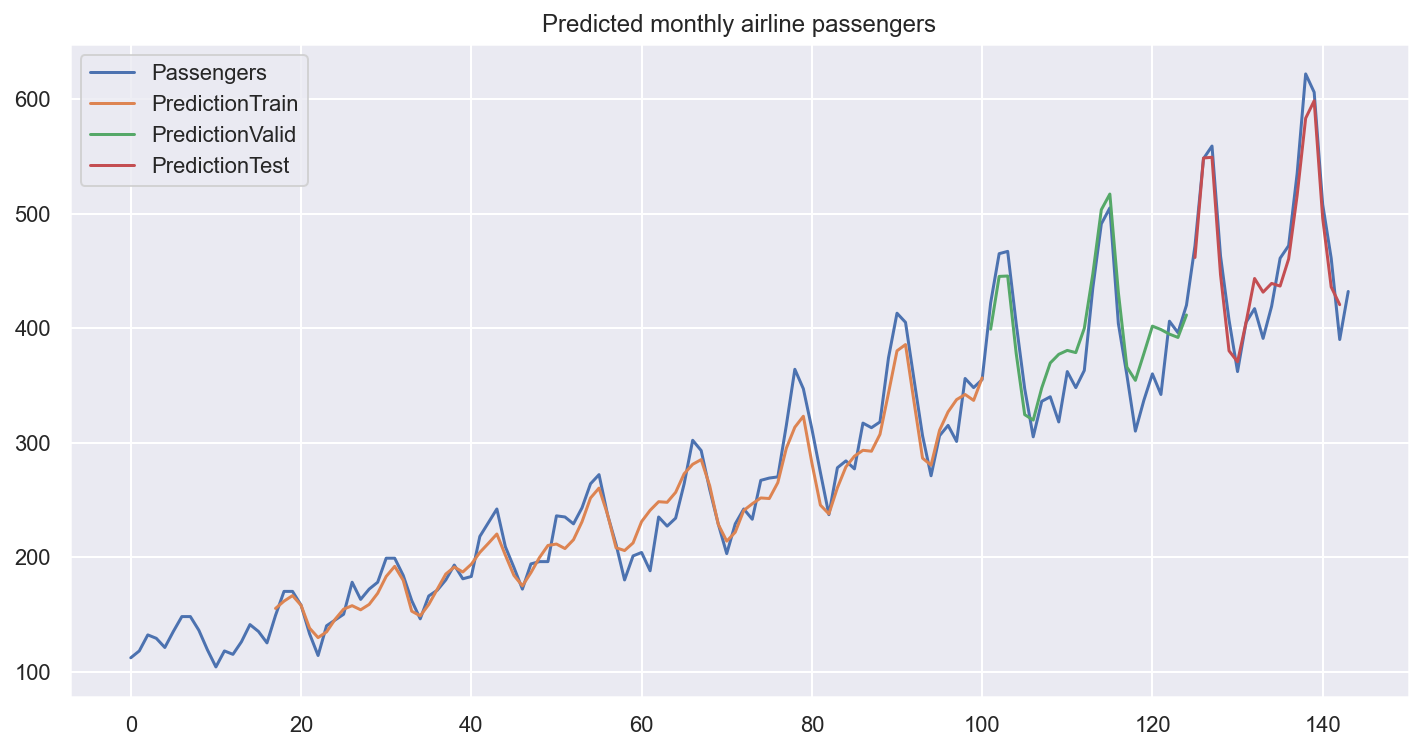

In [20]:
# Predict next 5 months
evaluate_model(data, scaler, X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, \
               X_encoder_test, X_decoder_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model, \
              pred_timesteps=DECODER_TIMESTEPS-1)